# PP Attachment

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops were holding a knife. The difference in the syntax parsing would be attaching the preposition phrase -

either to the **Verb** Phrase ("kill with knife")

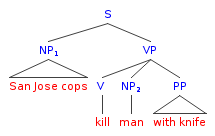

or to the **Noun** Phrase ("man with knife").

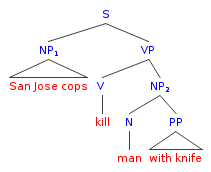


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [ ]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen


In [ ]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []

  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [ ]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [ ]:
pp_examples = read_pp_examples(pp_samples_url)

0it [00:00, ?it/s]

# Look at the data

In [ ]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


Some random sample:

In [ ]:
print(choice(pp_examples))

{'answer': 'V', 'keywords': ('put', 'pressure', 'on', 'GM')}


In [ ]:
random_example = choice(pp_examples)
random_example['keywords']

('learned', 'basics', 'from', 'lawyers')

In [ ]:
random_example['answer']

'V'

# Deciding on the measurement

In [ ]:
# we can split the dataset simply through dividing the list

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(f"training data size: {len(train_examples)}, test data size: {len(test_examples)}")

training data size: 19393, test data size: 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it just returns the accuracy score

In [ ]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])
      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Solution

## Statistical questions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(pp_examples)

In [ ]:
df

,answer,keywords
0,N,"(creating, obstacle, to, sale)"
1,V,"(restrict, RTC, to, borrowings)"
2,N,"(maintain, assets, of, thrifts)"
3,N,"(leaving, spending, for, bailout)"
4,V,"(leaving, spending, at, $)"
...,...,...
25853,V,"(finance, buy-out, at, price)"
25854,V,"(lowering, offer, to, $)"
25855,N,"(raise, rest, of, financing)"
25856,V,"(joined, forces, under, threat)"



How many examples of V and N do we have?

In [ ]:
df_by_answers = df.groupby('answer').count()
df_by_answers

,keywords
answer,
N,14094
V,11764


The number of examples is not devided equally, but the difference is not significant.

**How many intersections do we have?**

In [ ]:
# seperate wors to different columns
def unpack_keywords(df):
    # Create new columns for each keyword
    df[['keyword1', 'keyword2', 'keyword3', 'keyword4']] = pd.DataFrame(df['keywords'].tolist(), index=df.index)
    # Drop the original 'keywords' column
    df = df.drop('keywords', axis=1)
    return df

# Apply the function to your DataFrame
df_expanded = unpack_keywords(df)

# Display the updated DataFrame
display(df_expanded)


,answer,keyword1,keyword2,keyword3,keyword4
0,N,creating,obstacle,to,sale
1,V,restrict,RTC,to,borrowings
2,N,maintain,assets,of,thrifts
3,N,leaving,spending,for,bailout
4,V,leaving,spending,at,$
...,...,...,...,...,...
25853,V,finance,buy-out,at,price
25854,V,lowering,offer,to,$
25855,N,raise,rest,of,financing
25856,V,joined,forces,under,threat


In [ ]:
# Reshape the DataFrame
df_melted = pd.melt(df_expanded, id_vars=['answer'], value_vars=['keyword1', 'keyword2', 'keyword3', 'keyword4'], var_name='keyword_pos', value_name='keyword')
df_melted['position'] = df_melted['keyword_pos'].str.extract('(\d+)').astype(int)
df_melted = df_melted.drop('keyword_pos', axis=1)
df_melted['keyword'] = df_melted['keyword'].str.lower()
display(df_melted)


,answer,keyword,position
0,N,creating,1
1,V,restrict,1
2,N,maintain,1
3,N,leaving,1
4,V,leaving,1
...,...,...,...
103427,V,price,4
103428,V,$,4
103429,N,financing,4
103430,V,threat,4


In [ ]:
# Let's see how many unique words on each position we have
unique_answers_count = df_melted.groupby(['position', 'keyword'])['answer'].nunique().reset_index()
result_unique = unique_answers_count.groupby('position')['keyword'].count().reset_index()
result_unique.columns = ['position', 'unique_keywords_count']

# Let's see how many answer intersection on each position we have
multiple_answer_keywords = unique_answers_count[unique_answers_count['answer'] > 1]
result_intersections = multiple_answer_keywords.groupby('position')['keyword'].count().reset_index()
result_intersections.columns = ['position', 'multiple_answer_keywords_count']

result = pd.merge(result_intersections, result_unique, on='position')

result['percentage_of_intersections'] = result['multiple_answer_keywords_count'] / result['unique_keywords_count'] * 100
display(result)

,position,multiple_answer_keywords_count,unique_keywords_count,percentage_of_intersections
0,1,1355,3410,39.736070
1,2,1596,4682,34.087997
2,3,52,65,80.000000
3,4,1705,5651,30.171651


We can see that the biggest percent of intersections is on position 3 (the preposition).

Let's check what is the distribution of prepositions.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

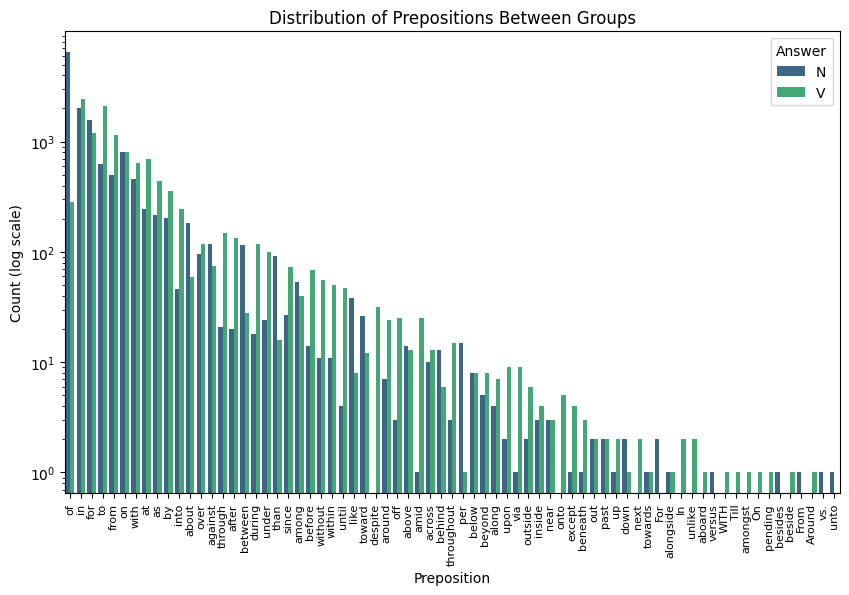

In [ ]:
# distribution of prepositions
df_subset = df_expanded[['answer', 'keyword3']]

plt.figure(figsize=(10, 6))
sns.countplot(x='keyword3', hue='answer', data=df_subset, palette='viridis', order=df_subset['keyword3'].value_counts().index)
plt.title('Distribution of Prepositions Between Groups')
plt.xlabel('Preposition')
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='Answer')
plt.show()

## Model initial

Throughout test, SVC showed the best performance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC


In [ ]:
class SVCClassifier:
    def __init__(self, training_examples: List[Tuple[str, List[str]]]):
        self.model_trained = False
        self.vectorizer, self.classifier = self.train_model(training_examples)

    def train_model(self, training_examples: List[Tuple[str, List[str]]]) -> Tuple[CountVectorizer, SVC]:
        X_train = [' '.join(item['keywords']) for item in training_examples]
        y_train = [item['answer'] for item in training_examples]

        vectorizer = TfidfVectorizer()
        X_train_vec = vectorizer.fit_transform(X_train)

        classifier = SVC()
        classifier.fit(X_train_vec, y_train)

        self.model_trained = True

        return vectorizer, classifier

    def classify(self, keywords: Tuple[str, str, str, str]) -> str:
        input_keywords = ' '.join(keywords)

        if not self.model_trained:
            raise RuntimeError("Model is not trained. Call train_model() before classify.")

        # Vectorize the input keywords using the same vectorizer
        input_keywords_vec = self.vectorizer.transform([input_keywords])
        prediction = self.classifier.predict(input_keywords_vec)[0]
        return prediction



In [ ]:
# Evaluate the classifier on test_examples
accuracy = evaluate_classifier(test_examples, SVCClassifier(train_examples))
print("Accuracy:", accuracy)

Accuracy: 0.8139211136890951


## Improving


Let's try to improve the perfomance testing other models

In [ ]:
from typing import List, Tuple
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB

class CustomClassifier:
    def __init__(self, training_examples: List[Tuple[str, List[str]]], vectorizer=None, classifier=None, vectorizer_param=None):
        self.model_trained = False
        self.vectorizer = vectorizer
        self.vectorizer_param = vectorizer_param
        self.classifier = classifier
        self.train_model(training_examples)

    def train_model(self, training_examples: List[Tuple[str, List[str]]]):
        X_train = [' '.join(item['keywords']) for item in training_examples]
        y_train = [item['answer'] for item in training_examples]

        if self.vectorizer is None or self.classifier is None:
            raise ValueError("Vectorizer and Classifier must be provided.")

        if self.vectorizer_param:
            self.vectorizer.set_params(**self.vectorizer_param)

        X_train_vec = self.vectorizer.fit_transform(X_train)
        self.classifier.fit(X_train_vec, y_train)

        self.model_trained = True

    def classify(self, keywords: Tuple[str, str, str, str]) -> str:
        input_keywords = ' '.join(keywords)

        if not self.model_trained:
            raise RuntimeError("Model is not trained. Call train_model() before classify.")

        input_keywords_vec = self.vectorizer.transform([input_keywords])
        prediction = self.classifier.predict(input_keywords_vec)[0]
        return prediction


In [ ]:
# List of vectorizers and classifiers
vectorizers = [CountVectorizer(), TfidfVectorizer()]
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), ComplementNB(), MultinomialNB()]
vectorizer_params = [{'ngram_range': (1, 1)}, {'ngram_range': (1, 2)}, {'ngram_range': (1, 3)}, {'ngram_range': (1, 4)}]

best_accuracy = 0
best_vectorizer = None
best_classifier = None

for vectorizer in vectorizers:
  for classifier in classifiers:
    for vectorizer_param in vectorizer_params:
      accuracy = evaluate_classifier(test_examples, CustomClassifier(train_examples, vectorizer=vectorizer, classifier=classifier, vectorizer_param=vectorizer_param))
      print(vectorizer, classifier, ' : ', accuracy)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_vectorizer = vectorizer
        best_classifier = classifier


CountVectorizer() SVC()  :  0.8218097447795824
CountVectorizer(ngram_range=(1, 2)) SVC()  :  0.8207269914926527
CountVectorizer(ngram_range=(1, 3)) SVC()  :  0.8064965197215778
CountVectorizer(ngram_range=(1, 4)) SVC()  :  0.8035576179427688
CountVectorizer() KNeighborsClassifier()  :  0.7798917246713071
CountVectorizer(ngram_range=(1, 2)) KNeighborsClassifier()  :  0.7710750193348801
CountVectorizer(ngram_range=(1, 3)) KNeighborsClassifier()  :  0.6708430007733952
CountVectorizer(ngram_range=(1, 4)) KNeighborsClassifier()  :  0.6694508894044857
CountVectorizer() RandomForestClassifier()  :  0.8194895591647332
CountVectorizer(ngram_range=(1, 2)) RandomForestClassifier()  :  0.8193348801237432
CountVectorizer(ngram_range=(1, 3)) RandomForestClassifier()  :  0.8134570765661253
CountVectorizer(ngram_range=(1, 4)) RandomForestClassifier()  :  0.8160866202629544
CountVectorizer() ComplementNB()  :  0.794431554524362
CountVectorizer(ngram_range=(1, 2)) ComplementNB()  :  0.8233565351894818
C

In [ ]:
print('Best accuracy: ',  best_accuracy, '\nVectorizer: ', best_vectorizer, '\nClassifier :',  best_classifier)

Best accuracy:  0.8233565351894818 
Vectorizer:  CountVectorizer(ngram_range=(1, 4)) 
Classifier : ComplementNB()
